In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.style.use('/Users/nik/Dropbox/Notebooks/talksrc.py')
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import glob
import os
import pandas as pd
import lvdatatools as lvdt
import re
import math

Going to try to find a noisy section of a quantum dot and exract some statistics about the random telegraph switching. The goal here is to plot the distribution of switching times as a fucntion of gate voltage over a noisy region of a coulomb diamond plot.

In [2]:
pkl_dir = '/Volumes/JUPITER/Data/fm_dots/SCF72/'
fig_dir = '/Volumes/JUPITER/Data/fm_dots/SCF72/figures/'
og_dir = '/Volumes/JUPITER/Data/SCF72/4K/'
os.listdir(pkl_dir)

['4K_BI_17-19_13_c_5mV_0mV.pkl',
 '4K_BI_17-19_13_d_5mV_0mV.pkl',
 '4K_BI_17-19_13_e_5mV_0mV.pkl',
 '4K_BI_17-19_13_i_10mV_0mV.pkl',
 '4K_gate-swp_17-29_13_b1.pk2',
 '4K_gate-swp_17-29_13_b1.pkl',
 '4K_VI-gate_17-19_13_f.pkl',
 '4K_VI-gate_17-19_13_g.pkl',
 '4K_VI-gate_17-19_13_g_n4T.pkl',
 '4K_VI-gate_23-21_13_f.pkl',
 'RT_gate-swp_15-23_13_a.pkl',
 '4K_VI-gate_17-19_13_g_cond.pkl',
 '4K_VI-gate_17-19_13_g_noise-amp.pkl',
 '4K_VI-gate_17-19_13_g_n4T_cond.pkl',
 '4K_VI-gate_17-19_13_g_n4T_noise-amp.pkl',
 'figures']

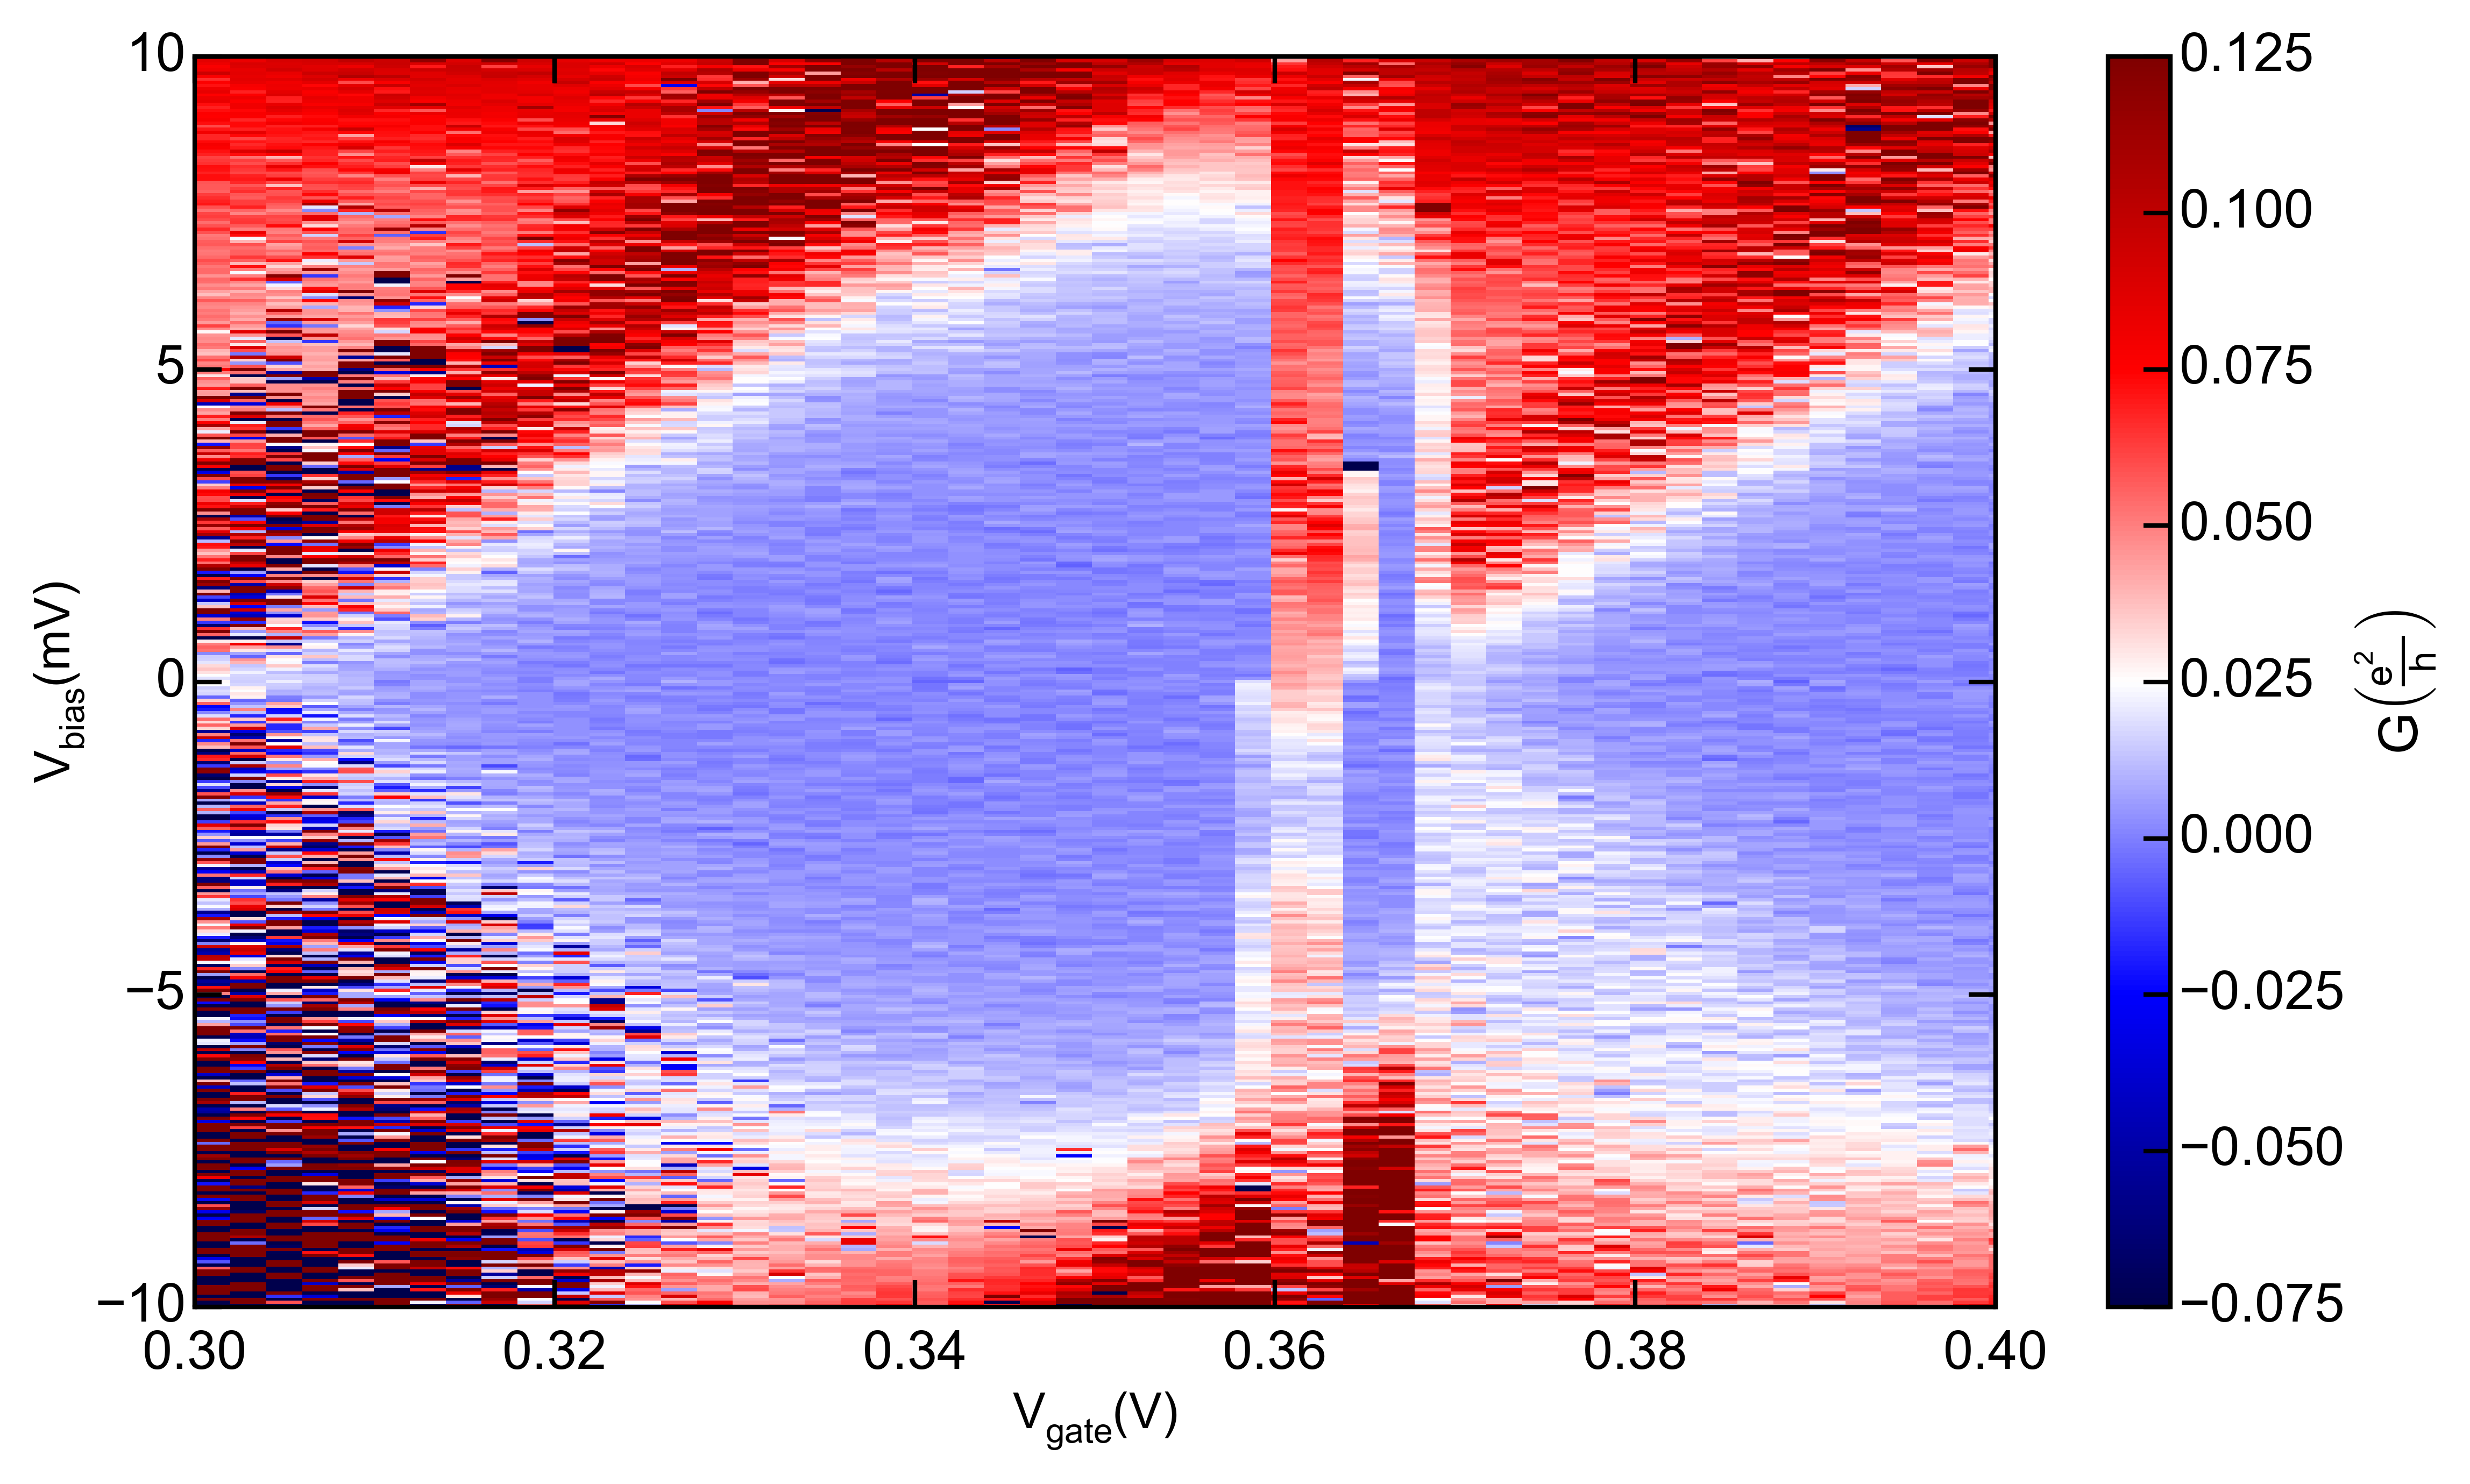

In [3]:
cond = pd.read_pickle(os.path.join(pkl_dir, '4K_VI-gate_17-19_13_g_cond.pkl'))

fig, ax = plt.subplots(figsize=(18,10))
limits = lvdt.df_extent(cond)

im = ax.imshow(cond/3.875e-5, extent = limits, 
               cmap = plt.cm.seismic, vmin = -0.075, vmax = 0.125, 
               origin = 'lower', aspect = 'auto', interpolation = 'nearest')
ax.set_xlabel(r'$V_{gate} (V)$', fontsize = 22)
ax.set_ylabel(r'$V_{bias} (mV)$', fontsize = 22)
ax.set_xlim(0.3, 0.4)
cb = plt.colorbar(im)
cb.set_label(r'$G \left(\frac{e^2}{h}\right)$')

# fig.savefig('/Users/nik/Dropbox/Repos/thesis/figures/chapter4/diamond_noise.png', dpi=300)

In [4]:
gate = cond.columns.values
filelist = [os.path.join(og_dir, 'VI-gate_17-19_13_g_{0:.0f}.bin'.format(g*1000)) for g in gate]
print np.all([os.path.isfile(f) for f in filelist]) # if this is false there is going to be trouble

True


In [5]:
np.linspace(0,200,21)

array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
         90.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,
        180.,  190.,  200.])

Great. Now I have the filelist for the dataset I want to work with. Time to start looking at some time series.

In [6]:
df = df.groupby(df['Bias']).mean()
fig, ax = plt.subplots()
ax.plot(df.index*1e3, df['Iavg']*1e9)

NameError: name 'df' is not defined

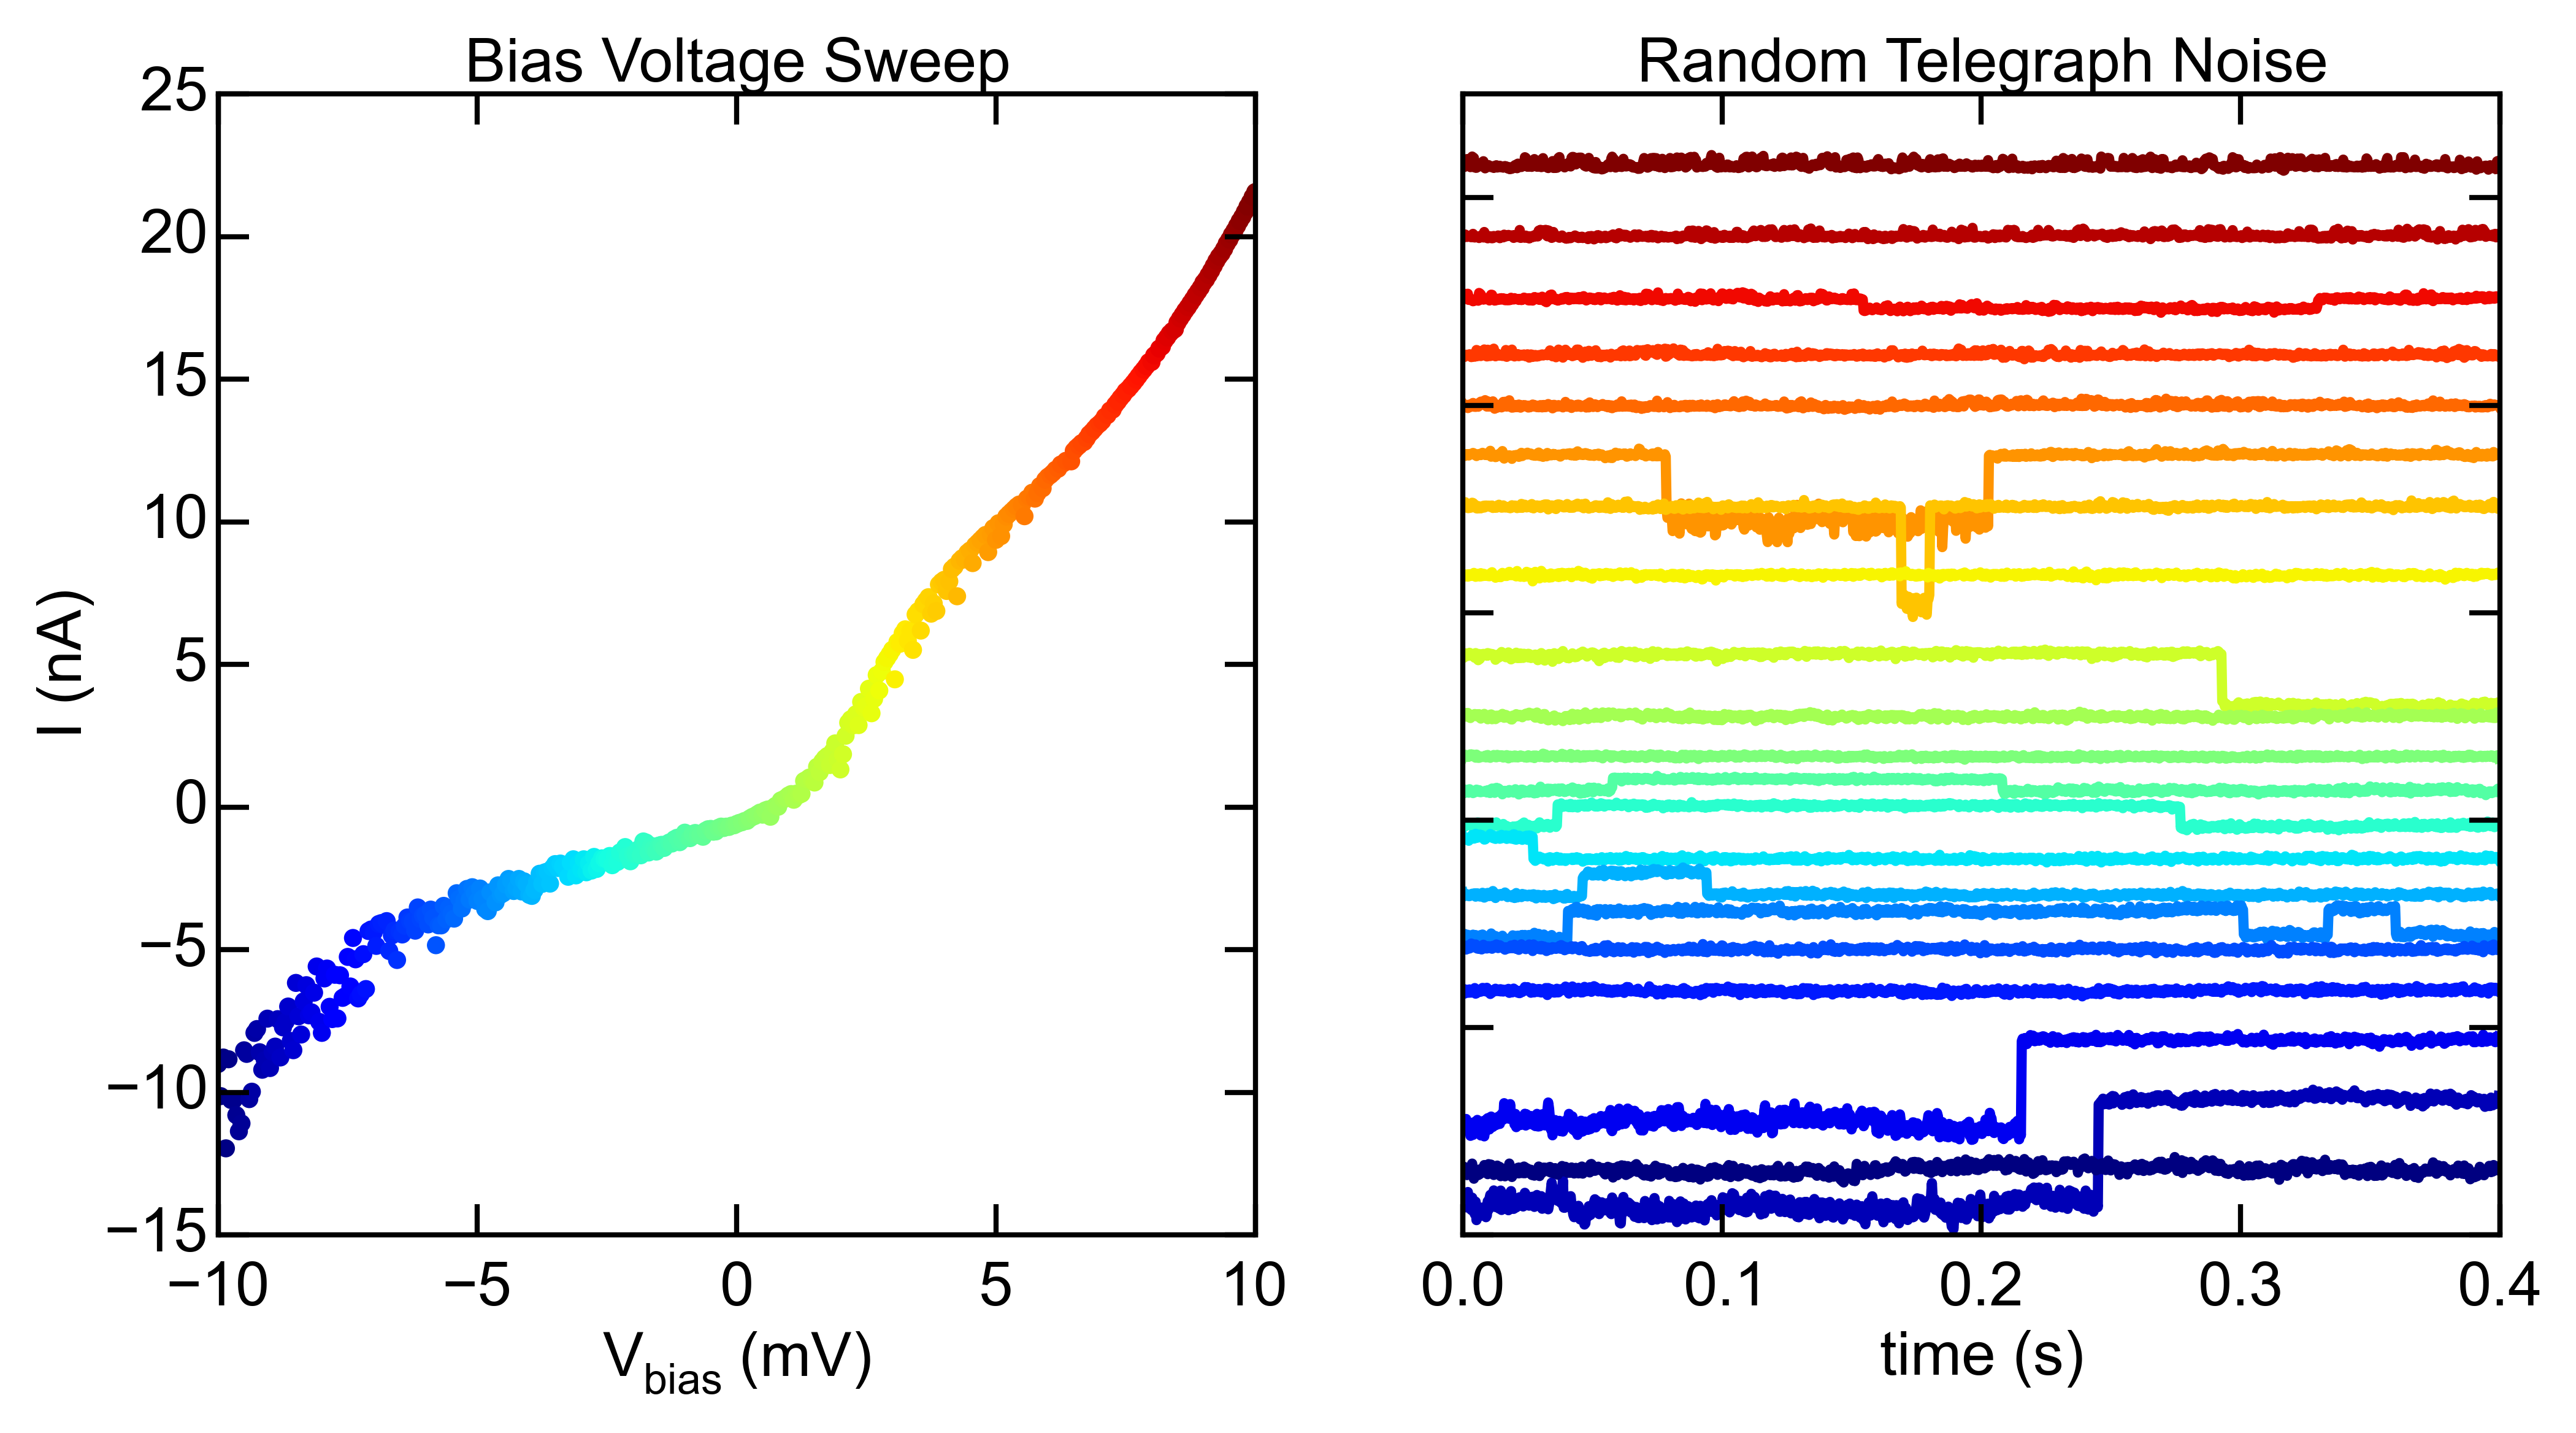

In [10]:
import matplotlib.ticker as ticker

gate = np.where(cond.columns.values==0.304)
df = lvdt.get_data_2d(filelist[gate[0]])

dt = df['dt'].mean()
N = len(df.loc[0,'i0':])
t = np.arange(0,N)*dt

M = 21
ind = np.linspace(201,602, M, dtype=np.int)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 8))
color_idx = np.linspace(1, 0, len(ind))

for i, n in enumerate(ind):
    ts = df.loc[n,'i0':].values*1e9-0.2*i**1.5
    bias = df['Bias'][n]*1e3
    #print len(ts), bias
    ax2.plot(t, ts, label = '{} mV'.format(bias), color=plt.cm.jet(color_idx[i]))
ax2.set_ylim(-30, 25)
# ax.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
# ax2.set_ylabel('I (nA)')
ax2.set_yticklabels([])
ax2.set_xlabel('time (s)')
ax2.set_title('Random Telegraph Noise')
ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.1))

df = df.groupby(df['Bias']).mean()
colors = np.linspace(0,1, len(df.index))
ax1.scatter(df.index*1e3, df['Iavg']*1e9, c=colors, cmap=plt.cm.jet,
            s = 50, edgecolor = 'none')
ax1.set_xlim(-10, 10)
ax1.set_ylabel('I (nA)')
ax1.set_xlabel('$V_{bias}$ (mV)')
ax1.set_title('Bias Voltage Sweep')

fig.savefig('/Users/nik/Dropbox/Talks/DEFENSE/figures/random_telegraph_noise.png')

That's a good illustration of what I'm working with here. What I need is some way to scale the measured currents in the time series by the 'expected' value so I can identify when it is in the 'correct' state and when it has switched. That should also make it easier to threshold the derivative to identify a switch.